In [15]:
import torch

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Modularity

In [17]:
%%writefile data_setup.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()


def create_dataloader(train_dir: str,
                      test_dir: str,
                      transform: transforms.Compose,
                      batch_size: int = 32,
                      num_workers: int = NUM_WORKERS//2):
    train_data = datasets.ImageFolder(root=train_dir, transform=transform)
    test_data = datasets.ImageFolder(root=test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(dataset=train_data,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True)

    test_dataloader = DataLoader(dataset=test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

    return train_dataloader, test_dataloader, class_names


Overwriting data_setup.py


In [18]:
import os
import torchvision
from torchvision import datasets
from pathlib import Path

data_path = Path("data")

train_dir = data_path / "Training"
test_dir = data_path / "Test"

weights = torchvision.models.ResNet50_Weights.DEFAULT
auto_transforms = weights.transforms()

train_data = datasets.ImageFolder(root=train_dir, transform=auto_transforms)

class_names = train_data.classes
class_names

['Apple 10',
 'Apple 11',
 'Apple 12',
 'Apple 13',
 'Apple 14',
 'Apple 17',
 'Apple 18',
 'Apple 19',
 'Apple 5',
 'Apple 7',
 'Apple 8',
 'Apple 9',
 'Apple Core 1',
 'Apple Red Yellow 2',
 'Apple worm 1',
 'Banana 3',
 'Beans 1',
 'Blackberrie 1',
 'Blackberrie 2',
 'Blackberrie half rippen 1',
 'Blackberrie not rippen 1',
 'Cabbage red 1',
 'Cactus fruit green 1',
 'Cactus fruit red 1',
 'Caju seed 1',
 'Cherimoya 1',
 'Cherry 3',
 'Cherry 4',
 'Cherry 5',
 'Cherry Rainier 2',
 'Cherry Rainier 3',
 'Cherry Sour 1',
 'Cherry Wax Red 2',
 'Cherry Wax Red 3',
 'Cherry Wax not ripen 1',
 'Cherry Wax not ripen 2',
 'Cucumber 10',
 'Cucumber 9',
 'Gooseberry 1',
 'Pistachio 1',
 'Quince 2',
 'Quince 3',
 'Quince 4',
 'Tomato 1',
 'Tomato 10',
 'Tomato 5',
 'Tomato 7',
 'Tomato 8',
 'Tomato 9',
 'Tomato Cherry Maroon 1',
 'Tomato Cherry Orange 1',
 'Tomato Cherry Red 2',
 'Tomato Cherry Yellow 1',
 'Tomato Maroon 2',
 'apple_6',
 'apple_braeburn_1',
 'apple_crimson_snow_1',
 'apple_golde

In [19]:
%%writefile engine.py

import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          save_dir: str="models",
          best_model_name: str="best_model.pth") -> Dict[str, List]:
    from pathlib import Path
    import torch

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    best_loss = float("inf")
    save_path = Path(save_dir) / best_model_name
    save_path.parent.mkdir(parents=True, exist_ok=True)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        if scheduler is not None:
            scheduler.step(test_loss)

        print(
            f"Epoch: {epoch + 1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        if test_loss < best_loss:
            best_loss = test_loss
            print(f"[INFO] Saving best model at epoch {epoch + 1} with test loss: {best_loss:.4f}")
            torch.save(model.state_dict(), save_path)

    return results


Overwriting engine.py


In [20]:
%%writefile utils.py

import torch
from pathlib import Path


def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True, exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "Model name must end with .pth or .pt"

    model_save_path = target_dir_path / model_name

    print("[INFO] Saving model to:", model_save_path)
    torch.save(model.state_dict(), model_save_path)

Overwriting utils.py


# Get the model

### Create datdasets and dataloaders

In [21]:
import torchvision
from torchvision import transforms

weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
weights.transforms()

manual_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [22]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [23]:
import data_setup

train_transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((260,260)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=train_transform,
                                                                              batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2495b611b20>,
 ['Apple 10',
  'Apple 11',
  'Apple 12',
  'Apple 13',
  'Apple 14',
  'Apple 17',
  'Apple 18',
  'Apple 19',
  'Apple 5',
  'Apple 7',
  'Apple 8',
  'Apple 9',
  'Apple Core 1',
  'Apple Red Yellow 2',
  'Apple worm 1',
  'Banana 3',
  'Beans 1',
  'Blackberrie 1',
  'Blackberrie 2',
  'Blackberrie half rippen 1',
  'Blackberrie not rippen 1',
  'Cabbage red 1',
  'Cactus fruit green 1',
  'Cactus fruit red 1',
  'Caju seed 1',
  'Cherimoya 1',
  'Cherry 3',
  'Cherry 4',
  'Cherry 5',
  'Cherry Rainier 2',
  'Cherry Rainier 3',
  'Cherry Sour 1',
  'Cherry Wax Red 2',
  'Cherry Wax Red 3',
  'Cherry Wax not ripen 1',
  'Cherry Wax not ripen 2',
  'Cucumber 10',
  'Cucumber 9',
  'Gooseberry 1',
  'Pistachio 1',
  'Quince 2',
  'Quince 3',
  'Quince 4',
  'Tomato 1',
  'Tomato 10',
  'Tomato 5',
  'Tomato 7',
  'Tomato 8',
  'Tomato 9',
  'Tomato Cherry Maroon 1',
  'Tomato Cherry Orange 1',
  'Tomato Cherry Red 2',
  'Tom

In [24]:
len(class_names)

78

## Getting a pretrained model

In [25]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
from torchinfo import summary

summary(model=model.to(device),
        input_size=(1, 3, 260, 260),
        device=device,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 260, 260]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 260, 260]     [1, 1280, 9, 9]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 260, 260]     [1, 32, 130, 130]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 260, 260]     [1, 32, 130, 130]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 130, 130]    [1, 32, 130, 130]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 130, 130]    [1, 32, 130, 130]    --                   --
│    └─Sequential (1)                                        [1, 32, 130, 130]    [1, 16, 130,

In [27]:
for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name:
        param.requires_grad = True
    else:
    	param.requires_grad = False

In [28]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [29]:
from torch import nn

model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=78, bias=True)
)

In [30]:
summary(model=model.to(device),
        input_size=(1, 3, 260, 260),
        device=device,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 260, 260]     [1, 78]              --                   Partial
├─Sequential (features)                                      [1, 3, 260, 260]     [1, 1280, 9, 9]      --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 260, 260]     [1, 32, 130, 130]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 260, 260]     [1, 32, 130, 130]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 130, 130]    [1, 32, 130, 130]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 130, 130]    [1, 32, 130, 130]    --                   --
│    └─Sequential (1)                                        [1, 32, 130, 130]    [1,

## Train the model

In [31]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [32]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

c:\Users\sandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [33]:
import engine

from timeit import default_timer as timer

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device,
                       scheduler=scheduler,
                       save_dir="models",
                       best_model_name="efficientNet_b0_food360_best.pth")

end_time = timer()

print(f"Total train time: {(end_time - start_time) :.3f} seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4594 | train_acc: 0.7145 | test_loss: 0.1398 | test_acc: 0.9789
[INFO] Saving best model at epoch 1 with test loss: 0.1398
Epoch: 2 | train_loss: 0.1871 | train_acc: 0.9629 | test_loss: 0.0326 | test_acc: 0.9936
[INFO] Saving best model at epoch 2 with test loss: 0.0326
Epoch: 3 | train_loss: 0.0941 | train_acc: 0.9767 | test_loss: 0.0146 | test_acc: 0.9974
[INFO] Saving best model at epoch 3 with test loss: 0.0146
Epoch: 4 | train_loss: 0.0615 | train_acc: 0.9843 | test_loss: 0.0094 | test_acc: 0.9975
[INFO] Saving best model at epoch 4 with test loss: 0.0094
Epoch: 5 | train_loss: 0.0507 | train_acc: 0.9866 | test_loss: 0.0074 | test_acc: 0.9977
[INFO] Saving best model at epoch 5 with test loss: 0.0074
Epoch: 6 | train_loss: 0.0385 | train_acc: 0.9888 | test_loss: 0.0065 | test_acc: 0.9979
[INFO] Saving best model at epoch 6 with test loss: 0.0065
Epoch: 7 | train_loss: 0.0323 | train_acc: 0.9910 | test_loss: 0.0087 | test_acc: 0.9973
Epoch: 8 | train_loss: 

In [34]:
import utils

utils.save_model(model=model,
                 target_dir="models",
                 model_name="efficientnetb0_food360.pth")

[INFO] Saving model to: models\efficientnetb0_food360.pth


In [35]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from typing import List, Tuple

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(260,260),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = image_transform(img).unsqueeze(0)

        target_image_pred = model(transformed_img.to(device))

        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label.item()]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)


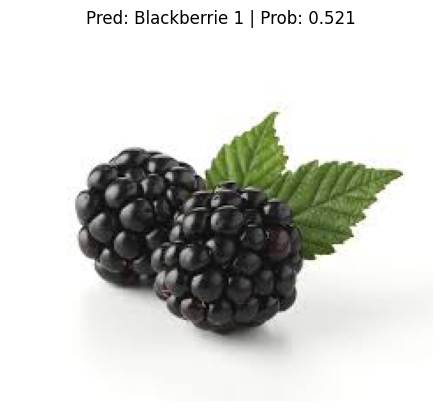

In [44]:
pred_and_plot_image(model=model,
                    image_path="blackberry_2.jpg",
                    class_names=class_names,
                    image_size=(260,260),
                    device=device)